<a href="https://www.kaggle.com/code/samarpanrai/nepal-premier-league-npl-analysis?scriptVersionId=250377054" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Nepal Premier League 2024 (Season 1) Analysis
The Nepal Premier League (NPL) is a T20 cricket league in Nepal. It was founded by the Cricket Association of Nepal (CAN) in 2024. The inaugural season was held from November 30, 2024 (15 Mangsir) to December 6, 2024 (6 Poush 2081 BS). The league features eight teams based on provinces and cities. The tournament follows a round-robin format, with the top teams advancing to the playoffs.


![Image](https://wicketnepal.com/wp-content/uploads/2024/11/468719762_122127843350455690_7601835368897814823_n.jpg)

There are 2 input files for this analysis. The `NPL matches` file is collected manually, and the `NPL_final` file is scraped from 2 websites ( [espncricinfo](https://espncricinfo.com)  &  [cricket](https://cricket.com) ) and cleaned manually. The `NPL_final` file is a combination of 2 datasets scraped from the commentary section, so some data may not be accurate. For example, both websites have some missing data, and the missing data was collected manually. Additionally, the commentary section of one website may differ from the other. For instance, in Match 1, Inning 1, Over 15.3, Rajesh Pulami is shown as run out on espncricinfo but as stumped on cricket.com. Therefore, there may be some inaccuracies in the data from both websites.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
npl = pd.read_csv('/kaggle/input/nepal-premier-league-2024-ball-by-ball-data/NPL matches.csv')
ball = pd.read_csv('/kaggle/input/nepal-premier-league-2024-ball-by-ball-data/NPL_final.csv')

In [3]:
print(npl.shape)
print(ball.shape)

(32, 27)
(7485, 20)


The `NPL matches` file contains 32 rows and 27 columns, with each row representing one match. Therefore, 32 matches were played in Season 1.

The `NPL_final` file contains 7,485 rows and 20 columns, with each row representing one ball bowled. In total, 7,485 balls were bowled in Season 1 of the NPL.

In [4]:
print(npl.info())
print(ball.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      32 non-null     int64  
 1   season                  32 non-null     int64  
 2   date                    32 non-null     object 
 3   venue                   32 non-null     object 
 4   city                    32 non-null     object 
 5   team_1                  32 non-null     object 
 6   team_2                  32 non-null     object 
 7   toss_winner             32 non-null     object 
 8   toss_decision           32 non-null     object 
 9   result                  32 non-null     object 
 10  dls_applied             32 non-null     int64  
 11  super_over              32 non-null     int64  
 12  winner                  32 non-null     object 
 13  team_1_runs             32 non-null     int64  
 14  team_2_runs             32 non-null     int6

## Input Files
The only missing datas are from `NPL_final` file with 4 columns having less data.

In [5]:
npl.head(5)

,id,season,date,venue,city,team_1,team_2,toss_winner,toss_decision,result,...,team_1_wickets,team_2_wickets,team_1_runs_from_extra,team_2_runs_from_extra,win_by_runs,win_by_wickets,player_of_the_match,over_balls,extra_balls,total_ball_bowled
0,1,2024,2024-11-30,Tribhuvan University International Cricket Gro...,Kathmandu,Biratnagar Kings,Janakpur Bolts,Janakpur Bolts,field,normal,...,10,2,15,22,0,8,Lahiru Milantha,207,17,224
1,2,2024,2024-12-02,Tribhuvan University International Cricket Gro...,Kathmandu,Kathmandu Gurkhas,Chitwan Rhinos,Chitwan Rhinos,field,normal,...,9,5,8,12,0,5,Sohail Tanvir,223,5,228
2,3,2024,2024-12-02,Tribhuvan University International Cricket Gro...,Kathmandu,Karnali Yaks,Janakpur Bolts,Karnali Yaks,bat,normal,...,7,2,8,4,0,8,Anil Sah,211,11,222
3,4,2024,2024-12-03,Tribhuvan University International Cricket Gro...,Kathmandu,Sudurpaschim Royals,Biratnagar Kings,Biratnagar Kings,field,normal,...,7,10,7,7,90,0,Dipendra Singh Airee,217,9,226
4,5,2024,2024-12-03,Tribhuvan University International Cricket Gro...,Kathmandu,Chitwan Rhinos,Pokhara Avengers,Pokhara Avengers,field,normal,...,7,10,5,11,87,0,Rijan Dhakal,200,9,209


In [6]:
ball.head(5)

,match_id,inning,batting_team,bowling_team,ball_over,ball_result,bowler,batsman,non_striker,shot_direction,player_dismissed,dismissal_kind,fielder,batsman_runs,wide_runs,bye_runs,legbye_runs,noball_runs,extra_runs,total_runs
0,1,1,Biratnagar Kings,Janakpur Bolts,0.1,0,Kishore Mahato,Lokesh Bam,Martin Guptill,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0
1,1,1,Biratnagar Kings,Janakpur Bolts,0.2,4,Kishore Mahato,Lokesh Bam,Martin Guptill,third man,NaN,NaN,NaN,4,0,0,0,0,0,4
2,1,1,Biratnagar Kings,Janakpur Bolts,0.3,0,Kishore Mahato,Lokesh Bam,Martin Guptill,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0
3,1,1,Biratnagar Kings,Janakpur Bolts,0.4,1w,Kishore Mahato,Lokesh Bam,Martin Guptill,NaN,NaN,NaN,NaN,0,1,0,0,0,1,1
4,1,1,Biratnagar Kings,Janakpur Bolts,0.4,0,Kishore Mahato,Lokesh Bam,Martin Guptill,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0


## Data Cleaning 
Some data cleaning might be needed, but I have not performed it in this notebook because it was already addressed during data collection. However, for deeper or more detailed analysis, additional cleaning could still be necessary.

# Toss Decision

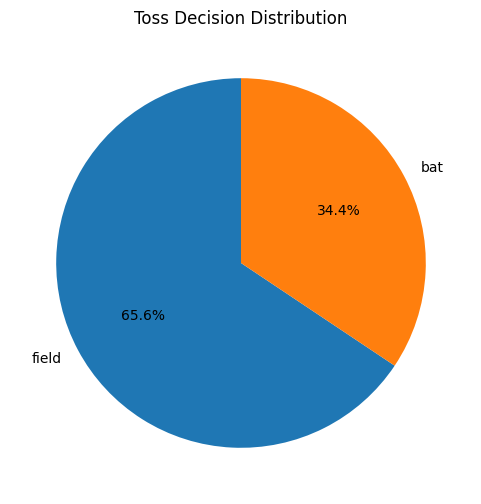

In [7]:
toss_counts = npl['toss_decision'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(toss_counts, labels=toss_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Toss Decision Distribution')
plt.show()

**65.5%** of the time, the captain chose to bowl first after winning the toss.

# Toss Impact
Does winning the toss increase your chances of winning the match?

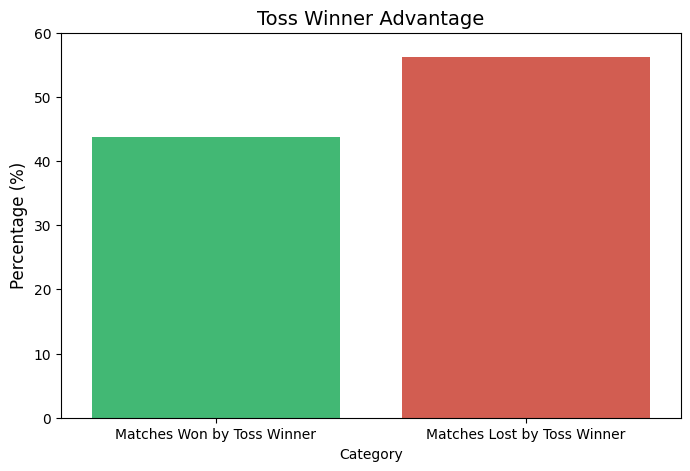

In [8]:
toss_winner_advantage = (npl['toss_winner'] == npl['winner']).mean() * 100
data = pd.DataFrame({
    'Category': ['Matches Won by Toss Winner', 'Matches Lost by Toss Winner'],
    'Percentage': [toss_winner_advantage, 100 - toss_winner_advantage]
})

plt.figure(figsize=(8, 5))
sns.barplot(x='Category', 
    y='Percentage', 
    data=data, 
    palette=['#2ecc71', '#e74c3c']
)
plt.title('Toss Winner Advantage', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=12)
plt.ylim(0, 60)
plt.show()

The graph shows that winning the toss does not necessarily guarantee victory. Teams have won the match only **43%** of the time after winning the toss.

# Chasing Vs Defending
Let's see whether batting or bowling first is advantageous in the inaugural edition of the NPL.

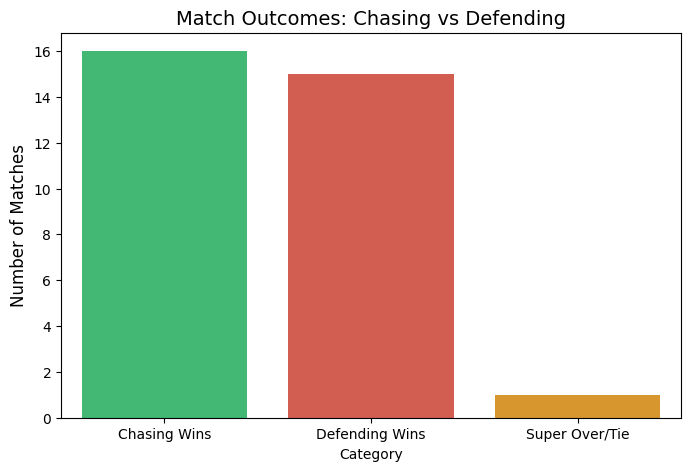

In [9]:
chasing_wins = len(npl[npl['win_by_wickets'] > 0])
defending_wins = len(npl[npl['win_by_runs'] > 0])
super_over_matches = len(npl) - (chasing_wins + defending_wins)

data = pd.DataFrame({
    'Category': ['Chasing Wins', 'Defending Wins', 'Super Over/Tie'],
    'Matches': [chasing_wins, defending_wins, super_over_matches]
})

plt.figure(figsize=(8, 5))
sns.barplot(
    x='Category', 
    y='Matches', 
    data=data, 
    palette=['#2ecc71', '#e74c3c', '#f39c12']
)
plt.title('Match Outcomes: Chasing vs Defending', fontsize=14)
plt.ylabel('Number of Matches', fontsize=12)
plt.show()

The graph above shows that it didn't matter whether a team was batting or bowling first, as 16 times teams won while chasing the game and 15 times teams won while defending the score.

**1 game ended in a Super Over**

# Win Percentage
The winning rate of each team with respect to the number of matches they have played.

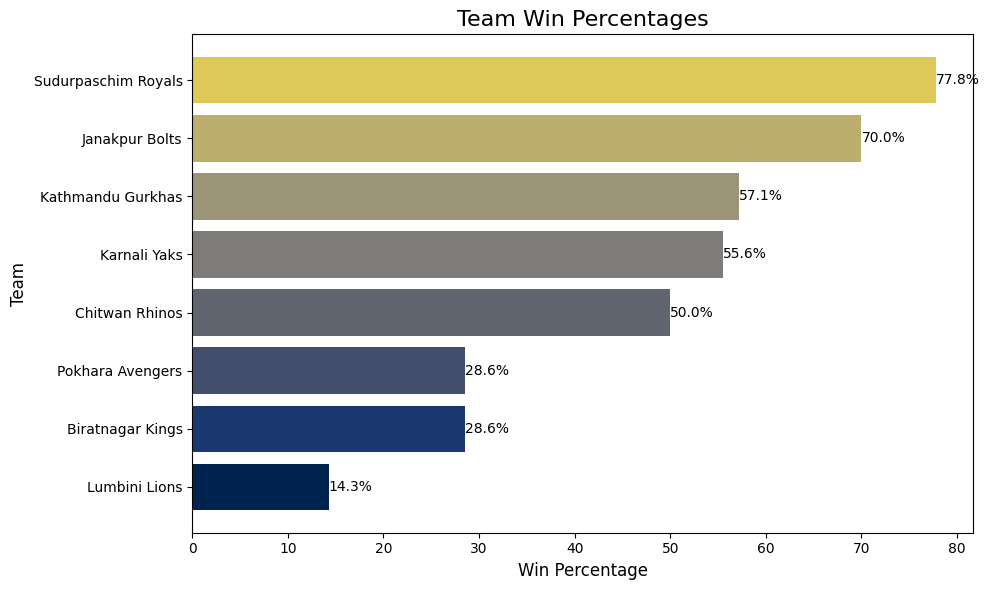

In [10]:
all_teams = pd.concat([npl['team_1'], npl['team_2']])  
matches_played = all_teams.value_counts().reset_index()
matches_played.columns = ['Team', 'Matches']  

wins = npl['winner'].value_counts().reset_index() 
wins.columns = ['Team', 'Wins'] 

win_percent = pd.merge(matches_played, wins, on='Team', how='left')  
win_percent['Wins'] = win_percent['Wins'].fillna(0) 
win_percent['Win Percentage'] = (win_percent['Wins'] / win_percent['Matches']) * 100

# Sort by win percentage for better visualization
win_percent = win_percent.sort_values('Win Percentage', ascending=True)  

num_teams = len(win_percent)
colors = plt.cm.cividis([i / num_teams for i in range(num_teams)])  

plt.figure(figsize=(10, 6))  
plt.barh(
    win_percent['Team'], 
    win_percent['Win Percentage'], 
    color=colors 
)

plt.xlabel('Win Percentage', fontsize=12)
plt.ylabel('Team', fontsize=12)
plt.title('Team Win Percentages', fontsize=16)

# Adding percentage values on the bars
for index, value in enumerate(win_percent['Win Percentage']):
    plt.text(value, index, f'{value:.1f}%', va='center')
plt.tight_layout()
plt.show()

`Sudurpaschim Royals` has the highest win percentage in the tournament, with 77.8% (7 wins in 9 matches).

# Team Discipline (Extras Conceded)
Extra runs conceded by each team in the tournament 

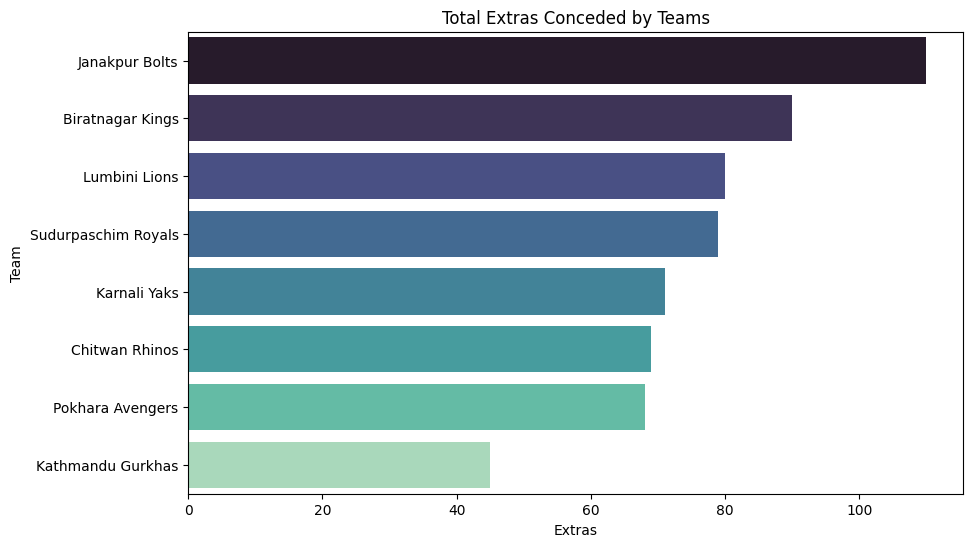

Total Extras in Tournament: 612


In [11]:
team_extras = {}
for team in npl['team_1'].unique():
    team_extras[team] = npl[npl['team_1'] == team]['team_1_runs_from_extra'].sum() + \
                        npl[npl['team_2'] == team]['team_2_runs_from_extra'].sum()
    
extras_df = pd.DataFrame(list(team_extras.items()), columns=['Team', 'Extras']).sort_values('Extras', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Extras', y='Team', data=extras_df, palette='mako')
plt.title('Total Extras Conceded by Teams')
plt.show()

total_extras = npl['team_1_runs_from_extra'].sum() + npl['team_2_runs_from_extra'].sum()
print(f"Total Extras in Tournament: {total_extras}")

`Janakpur Bolts` is the team that has conceded the most extras, with a total of 106 runs in extras, averaging **10.6** per match.

# Top 5 Players with the most man of the match awards

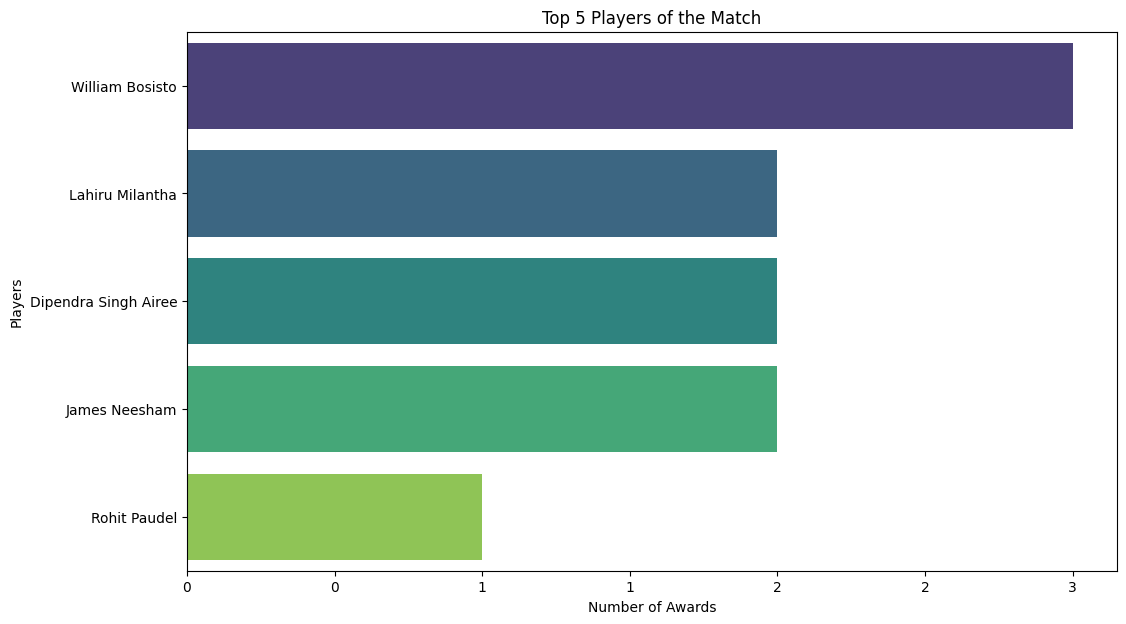

In [12]:
player_counts = npl['player_of_the_match'].value_counts().head(5)

plt.figure(figsize=(12,7))
sns.barplot(x=player_counts.values, y=player_counts.index, palette='viridis')

plt.title('Top 5 Players of the Match')
plt.xlabel('Number of Awards')
plt.ylabel("Players")

plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
plt.show()

# Batsmen Section
## Top Batsmen of the Tournament
Viewing the top 10 run scorers from Season 1

In [13]:
runs = ball.groupby('batsman')['batsman_runs'].sum().sort_values(ascending=False)

top_batsmen = runs[:10].reset_index()  
top_batsmen.columns = ['Batsman', 'Runs']  

fig = px.bar(
    top_batsmen,
    x='Batsman',
    y='Runs',
    hover_data=['Batsman', 'Runs'],
    color='Runs',
    title='Top 10 Batsmen in NPL Season 1'
)
fig.show(renderer='iframe')

## Runs Scored by a Batsman Against Each Team
The dropdown button displays the runs scored by a batsman against each team. Only batsmen who have scored more than 130 runs are included in the dropdown.

In [14]:
total_runs = ball.groupby('batsman')['batsman_runs'].sum().reset_index()
qualified_batsmen = total_runs[total_runs['batsman_runs'] > 130]['batsman'].tolist()

fig = go.Figure()

buttons = []
trace_idx = 0

for batsman in qualified_batsmen:
    mask = ball['batsman'] == batsman
    filtered_data = ball[mask]
    runs_by_team = filtered_data.groupby('bowling_team')['batsman_runs'].sum().sort_values()

    fig.add_trace(go.Bar(
        x=runs_by_team.values,
        y=runs_by_team.index,
        orientation='h',
        name=batsman,
        marker_color='#FF4545',
        visible=(trace_idx == 0)
    ))

    vis_mask = [False] * len(qualified_batsmen)
    vis_mask[trace_idx] = True

    buttons.append(dict(
        label=batsman,
        method='update',
        args=[
            {'visible': vis_mask},
            {'title': f'Runs Scored by {batsman} Against Each Team'}
        ]
    ))

    trace_idx += 1

fig.update_layout(
    title=f'Runs Scored by {qualified_batsmen[0]} Against Each Team',
    xaxis_title='Runs Scored',
    yaxis_title='Bowling Team',
    updatemenus=[
        dict(
            active=0,
            buttons=buttons,
            direction='down',
            showactive=True,
            x=0.1,
            xanchor='left',
            y=1.11,
            yanchor='top'
        )
    ],
    showlegend=False
)

fig.show(renderer='iframe')

**NOTE: If it is not working properly, it might be due to an issue with the interactive function. Try downloading the notebook and running it locally.**

Rohit Paudel scored 95 runs against *Pokhara Avengers* and 80 runs against *Chitwan Rhinos*, among others. You can replace his name with any other player to retrieve their data.

## Batsmen with the most 6's in the tournament

In [15]:
mask = ball['batsman_runs'] == 6
new_ball = ball[mask]

dots = new_ball.groupby('batsman').size().sort_values(ascending=False).head(10)
top_batsmen = dots[:10].reset_index()  # Reset index to make it a DataFrame
top_batsmen.columns = ['Batsman', 'Runs']  # Rename columns for clarity

fig = px.bar(
    top_batsmen,
    x='Batsman',
    y='Runs',
    hover_data=['Batsman', 'Runs'],
    color='Runs',
    title="Top 10 Batsmen with the most 6's in NPL Season 1"
)
fig.show(renderer='iframe')

## Batsmen with the most 4's in the tournament

In [16]:
mask = ball['batsman_runs'] == 4
new_ball = ball[mask]

dots = new_ball.groupby('batsman').size().sort_values(ascending=False).head(10)
top_batsmen = dots[:10].reset_index()  # Reset index to make it a DataFrame
top_batsmen.columns = ['Batsman', 'Runs']

fig = px.bar(
    top_batsmen,
    x='Batsman',
    y='Runs',
    hover_data=['Batsman', 'Runs'],
    color='Runs',
    title="Top 10 Batsmen with the most 4's in NPL Season 1"
)
fig.show(renderer='iframe')

## Comparing Batsmen with the Most Dot Balls and Their Strike Rates
Below is a bar graph showing the batsmen with the most dot balls played and their respective strike rates in the tournament. This illustrates whether the batsmen have compensated for their dot balls with hitting, as reflected in their strike rates.

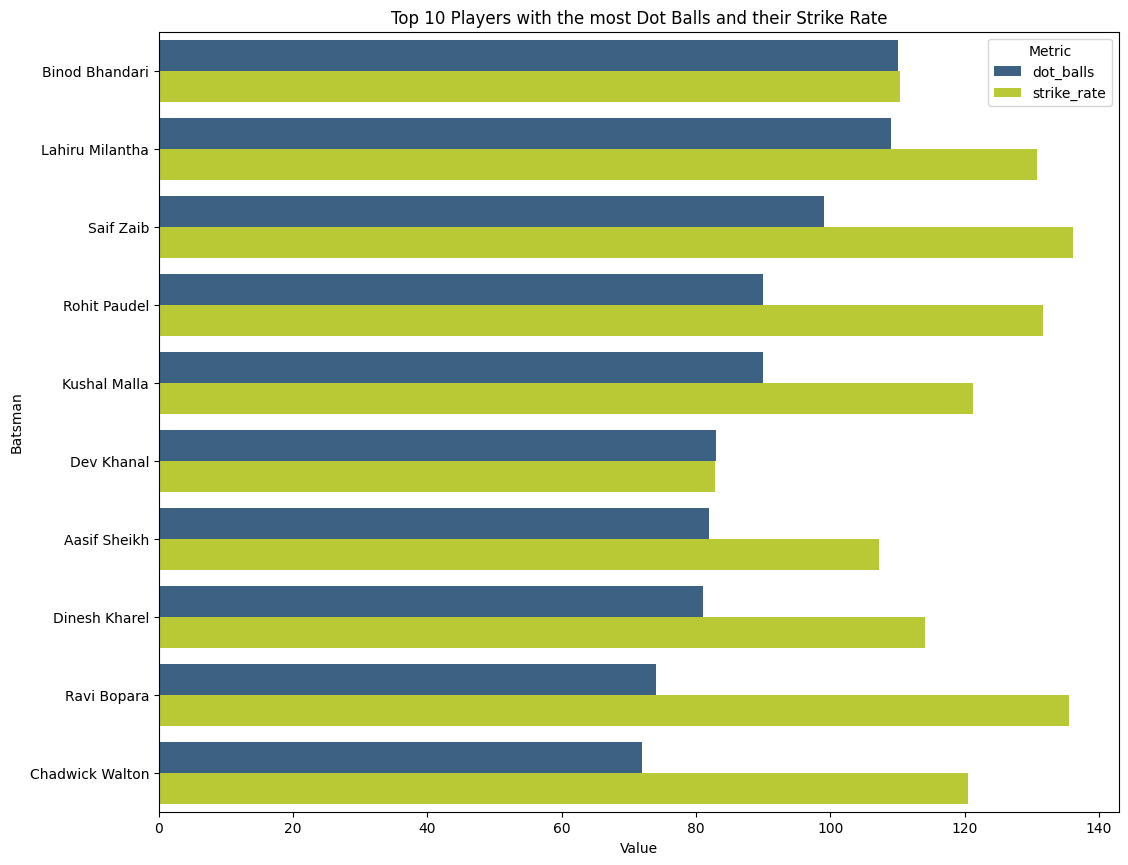

,batsman,dot_balls,strike_rate
25,Binod Bhandari,110,110.377358
61,Lahiru Milantha,109,130.803571
91,Saif Zaib,99,136.138614
88,Rohit Paudel,90,131.603774
60,Kushal Malla,90,121.195652
34,Dev Khanal,83,82.857143
5,Aasif Sheikh,82,107.284768
38,Dinesh Kharel,81,114.084507
83,Ravi Bopara,74,135.545024
30,Chadwick Walton,72,120.529801


In [17]:
filtered_ball = ball[(ball["wide_runs"] == 0) & (ball["noball_runs"] == 0)]

# Aggregating batting statistics
batting_stats = filtered_ball.groupby("batsman").agg(
    total_runs=pd.NamedAgg(column="batsman_runs", aggfunc="sum"),
    balls_faced=pd.NamedAgg(column="ball_over", aggfunc="count"),
).reset_index()

batting_stats["strike_rate"] = (batting_stats["total_runs"] / batting_stats["balls_faced"]) * 100
batting_stats = batting_stats.fillna(0).sort_values(by="total_runs", ascending=False)

dot_balls = ball[ball["batsman_runs"] == 0].groupby("batsman").size().reset_index(name="dot_balls")
dot_balls = dot_balls.merge(batting_stats[["batsman", "strike_rate"]], on="batsman", how="left")

top_dot_ball_players = dot_balls.sort_values(by="dot_balls", ascending=False).head(10)

melted_data = top_dot_ball_players.melt(id_vars=["batsman"], value_vars=["dot_balls", "strike_rate"],
                                        var_name="Metric", value_name="Value")

first_bar = '#32628d'  
second_bar = '#cde01d' 

# Creating horizontal grouped bar chart with small gap between same Metric and large gap between different Metrics
plt.figure(figsize=(12, 6))
sns.barplot(x="Value", y="batsman", hue="Metric", data=melted_data, 
            palette=[first_bar, second_bar], orient="h", width=0.8)

# Adjusting space between the groups manually
plt.subplots_adjust(left=0.1, right=0.9, top=1.4, bottom=0.1)

plt.xlabel("Value")
plt.ylabel("Batsman")
plt.title("Top 10 Players with the most Dot Balls and their Strike Rate")

plt.show()
top_dot_ball_players[["batsman", "dot_balls", "strike_rate"]]

### Analysing Dot Balls and Strike Rates

From the graph above, we can see that `Binod Bhandari` has played the most dot balls, but his strike rate is above 110, which is considered good for a T20 match. 

On the other hand, `Dev Khanal` has the lowest strike rate among the batsmen with the most dot balls, at 82.25. However, it's important to note that this analysis does not take into account the match situation, the batsman's batting position, or the required runs, all of which might contribute to a lower strike rate. Therefore, this metric is not intended to target any individual player but to highlight which players have compensated for their dot balls the most.

`Saif Zaib` has the highest strike rate among the batsmen with the most dot balls played, meaning he has compensated the most for his dot balls.


# Bowlers Section
## Top Bowlers of the Tournament
Viewing the top 10 wicket takers form season 1

In [18]:
mask = ball[~ball['dismissal_kind'].isin(['Runout', 'Retired Hurt'])]

wickets = mask.groupby('bowler')['dismissal_kind'].count().reset_index(name='Wickets')
top_bowlers = wickets.sort_values(by='Wickets', ascending=False).head(10)
top_bowlers.columns = ['Bowler', 'Wickets']

fig = px.bar(
    top_bowlers, 
    x='Wickets', 
    y='Bowler', 
    hover_data=['Bowler'], 
    color='Wickets',
    title='Top 10 Bowlers in NPL 2024',
    orientation='h'
)

fig.show(renderer='iframe')

## Bowlers with the Most Dot Balls
These are the bowlers who delivered the highest number of dot balls in the tournament.

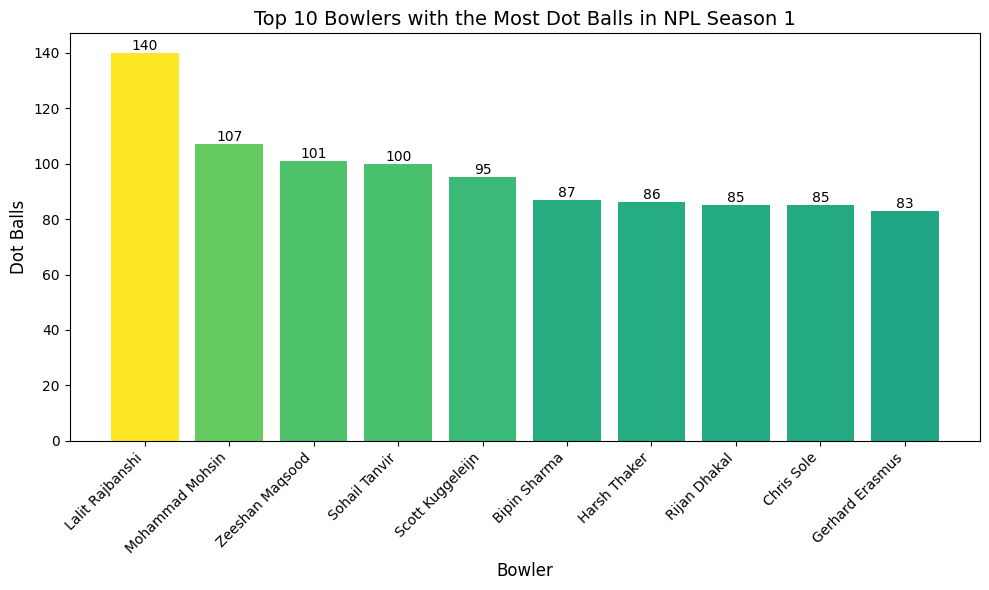

In [19]:
mask = (ball['batsman_runs'] == 0) & (ball['noball_runs'] == 0) & (ball['wide_runs'] == 0)
new_ball = ball[mask]

dots = new_ball.groupby('bowler').size().sort_values(ascending=False).head(10)

# Converting to DataFrame
top_bowlers = dots.reset_index()
top_bowlers.columns = ['Bowler', 'Balls']

plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(top_bowlers['Balls'] / max(top_bowlers['Balls'])) 
bars = plt.bar(top_bowlers['Bowler'], top_bowlers['Balls'], color=colors)

# Adding numbers above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', 
             ha='center', va='bottom', fontsize=10)

plt.title('Top 10 Bowlers with the Most Dot Balls in NPL Season 1', fontsize=14)
plt.xlabel('Bowler', fontsize=12)
plt.ylabel('Dot Balls', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

`Lalit Rajbanshi` is by far the best bowler in the tournament, leading in both wickets and dot balls while maintaining an economy rate under 6.

# Distribution of Shot Directions in the Tournament
This pie chart visualizes the distribution of different shot directions used by players during the tournament. It highlights the frequency of each shot direction, offering insights into the most preferred areas for scoring runs. The chart provides a clear view of the players' shot selection tendencies throughout the games.

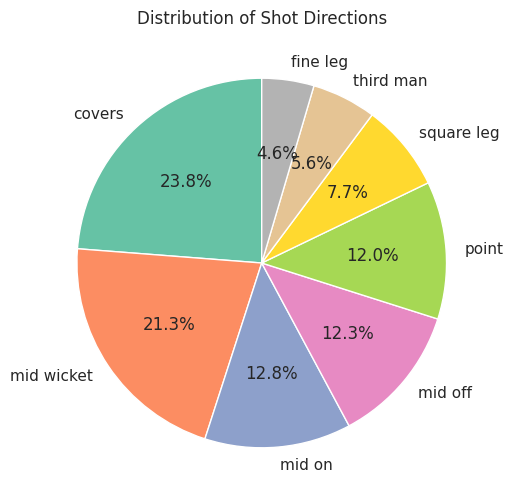

In [20]:
shot_direction_counts = ball['shot_direction'].value_counts()

plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

plt.pie(shot_direction_counts, labels=shot_direction_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2", len(shot_direction_counts)))
plt.title('Distribution of Shot Directions')
plt.show()

## Shot Direction Analysis for Individual Players
This shows the preferred shot direction of each player. You can select a player's name from the dropdown menu below to view their favorite region for scoring runs. To keep the list manageable, only batsmen with more than 130 runs are included in the dropdown.

In [21]:
# Filtering qualified batsmen
total_runs = ball.groupby('batsman')['batsman_runs'].sum().reset_index()
qualified_batsmen = total_runs[total_runs['batsman_runs'] > 130]['batsman'].tolist()

fig = go.Figure()

buttons = []
trace_idx = 0

for batsman in qualified_batsmen:
    mask = ball['batsman'] == batsman
    filtered_data = ball[mask]
    direction = filtered_data.groupby('shot_direction')['batsman_runs'].sum().sort_values(ascending=True)

    fig.add_trace(go.Bar(
        x=direction.values,
        y=direction.index,
        orientation='h',
        name=batsman,
        marker=dict(color='#16C47F'),
        visible=(trace_idx == 0)  
    ))

    # Building visibility mask
    vis_mask = [False] * len(qualified_batsmen)
    vis_mask[trace_idx] = True

    buttons.append(dict(
        label=batsman,
        method='update',
        args=[
            {'visible': vis_mask},
            {'title': f'Shot Direction Preferred by {batsman}'}
        ]
    ))

    trace_idx += 1

# Adding dropdown
fig.update_layout(
    title=f'Shot Direction Preferred by {qualified_batsmen[0]}',
    xaxis_title="Runs Scored",
    yaxis_title="Shot Direction",
    updatemenus=[
        dict(
            active=0,
            buttons=buttons,
            direction='down',
            showactive=True,
            x=0.1,
            xanchor='left',
            y=1.11, 
            yanchor='top'
        )
    ],
    showlegend=False
)

fig.show(renderer='iframe')

**NOTE: If it is not working properly, it might be due to an issue with the interactive function. Try downloading the notebook and running it locally.**

# Top 5 Best Pairs in the Tournament
The top 5 pairs in the tournament were determined by calculating the total partnership runs scored by each duo across all the games they played together.

In [22]:
# Created sorted player pairs to treat (A,B) and (B,A) as the same partnership
ball_sorted = ball.copy()
ball_sorted[['player1', 'player2']] = ball_sorted.apply(
    lambda row: sorted([row['batsman'], row['non_striker']]), 
    axis=1, 
    result_type='expand'
)

# Group by the sorted pairs and sum runs
partnerships = (
    ball_sorted.groupby(['player1', 'player2'])['batsman_runs']
    .sum()
    .reset_index()
    .sort_values('batsman_runs', ascending=False)
    .head(5)
)

partnerships['partnership'] = partnerships['player1'] + ' & ' + partnerships['player2']

fig = px.bar(
    partnerships,
    x='partnership',  
    y='batsman_runs',
    title='Top 5 Batting Partnerships (Overall)',
    labels={'batsman_runs': 'Partnership Runs'},
    color='partnership',
)
fig.show(renderer='iframe')

`Andries Gous` and `Dinseh Kharel` are the best duo in the tournament, with 327 runs scored between them throughout the competition.

# Phase-wise Bowling Performance
Analyzing the wickets taken by bowlers according to the different phases of the game.

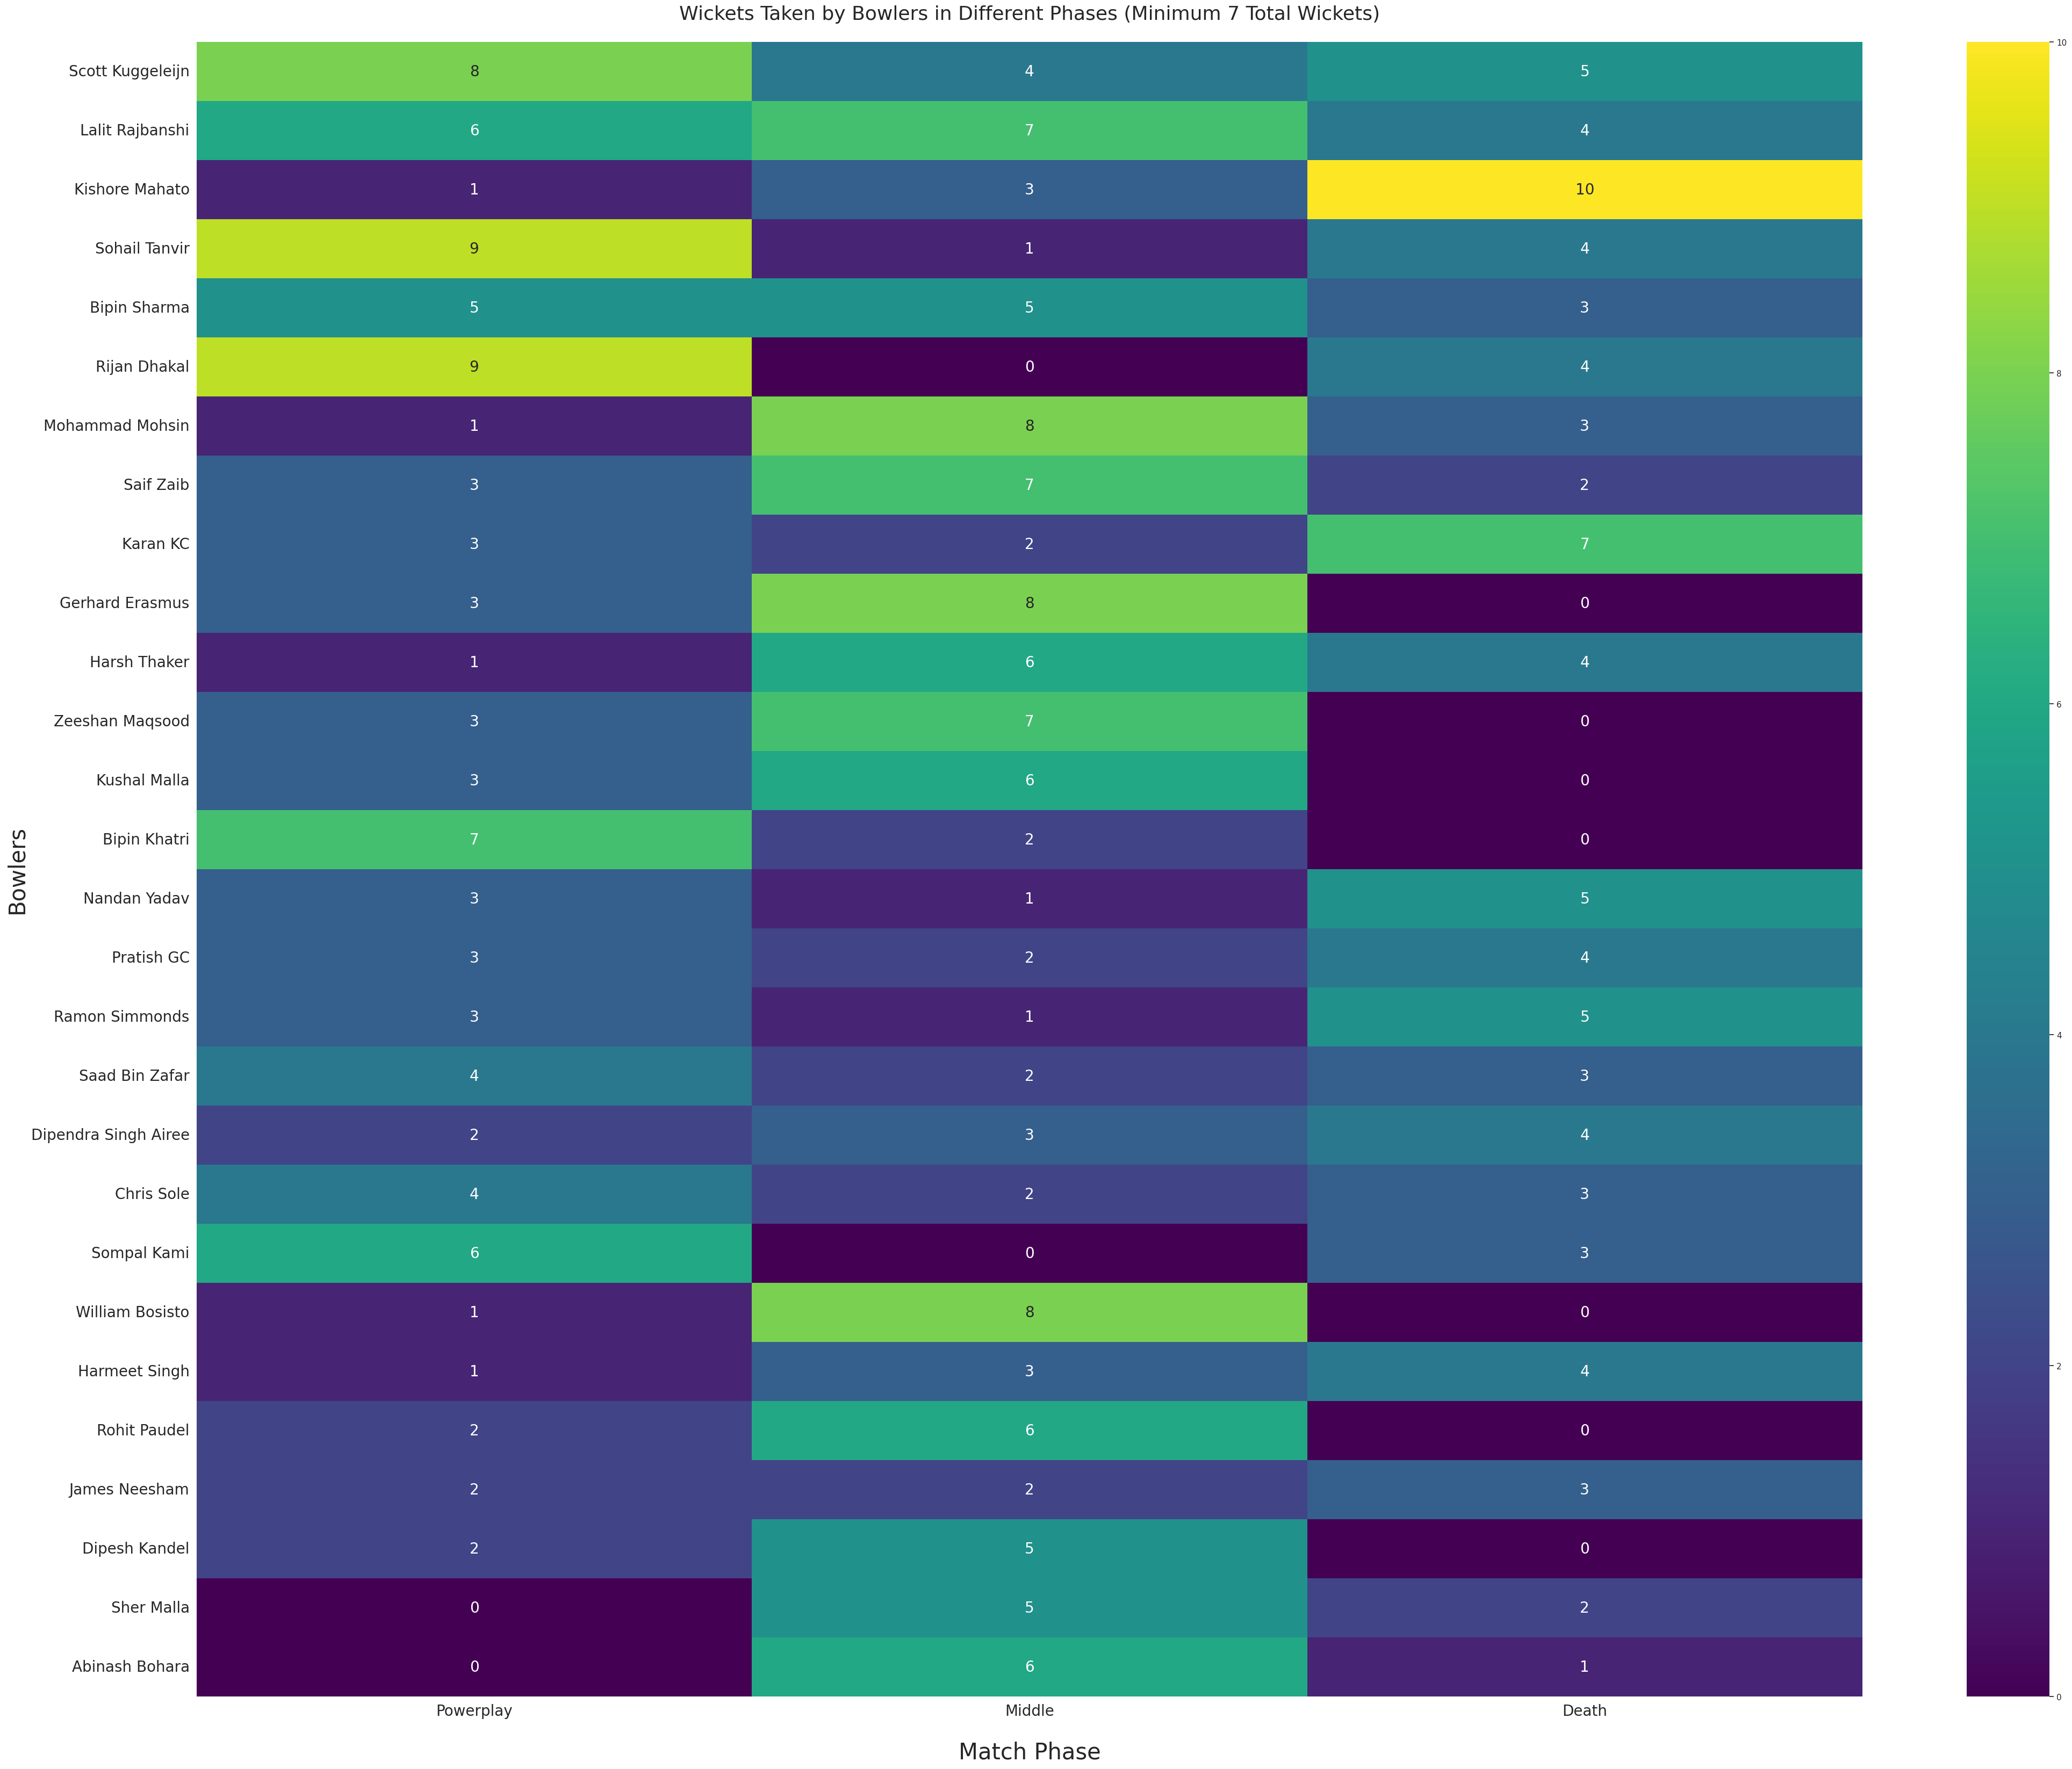

In [23]:
ball['ball_over'] = pd.to_numeric(ball['ball_over'], errors='coerce')
ball['phase'] = pd.cut(ball['ball_over'],
                      bins = [0, 6, 16, 20],
                      labels = ['Powerplay','Middle','Death'],
                      right=False)

mask = ~ball['dismissal_kind'].isin(['Runout', 'Retired Hurt'])
filtered_ball = ball[mask]

# when doing groupby use reset_index() to convert it into structured dataframe
phase_wk = filtered_ball.groupby(['bowler','phase'], observed=False)['dismissal_kind'].count().reset_index()

total_wk = phase_wk.groupby('bowler')['dismissal_kind'].sum().reset_index()
total_wk.rename(columns={'dismissal_kind':'total_wk'}, inplace=True)

# Sorting accordin to total wickets
sorted_bowlers = total_wk[total_wk['total_wk'] > 6].sort_values(by='total_wk', ascending=False)['bowler']

phase_wk = phase_wk.merge(total_wk, on='bowler')
phase_wk = phase_wk[phase_wk['bowler'].isin(sorted_bowlers)]

final= phase_wk.pivot(index='bowler', columns='phase', values='dismissal_kind').fillna(0)
final = final.reindex(index=sorted_bowlers) 

plt.figure(figsize=(50, 40))
sns.heatmap(final, cmap='viridis', annot=True, annot_kws={'size': 20})
plt.title("Wickets Taken by Bowlers in Different Phases (Minimum 7 Total Wickets)", fontsize=26, pad=30)
plt.xlabel("Match Phase", fontsize=30, labelpad=30)
plt.ylabel("Bowlers", fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

From the above heatmap, we can see that `Rijan Dhakal` and `Sohail Tanvir` have the most wickets in **Powerplay Overs** with 9 wickets each, while `William Bosisto`, `Gerhard Erasmus`, and `Mohammad Mohsin` dominate the **Middle Overs** with 8 wickets each. Lastly, `Kishore Mahato` has the most wickets in **Death Overs** with 10 wickets.

# Phase-wise Batting Performance
This section highlights the **phase-wise batting performance** of all players in **Season 1**. The phases are categorized as follows:  
- **Powerplay (0-6 Overs)**  
- **Middle Overs (6-16 Overs)**  
- **Death Overs (16-20 Overs)**  

You can view the **runs scored** and **strike rate** of each player during every phase of the game.  

- `Dipendra Singh Airee` and `Ravi Bopara` emerge as the most lethal players in the **death overs**, among players with more than 50 runs and a strike rate exceeding **200**.  
- `James Neesham` dominates the **middle overs**, scoring just over 200 runs with an impressive strike rate of **201**. 

In [24]:
# Preprocessing
ball['ball_over'] = pd.to_numeric(ball['ball_over'], errors='coerce')
ball['phase'] = pd.cut(ball['ball_over'],
                      bins=[0, 6, 16, 20],
                      labels=['Powerplay', 'Middle', 'Death'],
                      right=False)

phase_sr = ball[ball['wide_runs'] == 0].groupby(['batsman', 'phase'], observed=False)['batsman_runs'].agg(['sum', 'count'])
phase_sr['sr'] = (phase_sr['sum'] / phase_sr['count']) * 100
phase_sr = phase_sr.reset_index().sort_values('sr', ascending=False)
fig = px.scatter(phase_sr, x='sum', y='sr', color='phase', hover_data=['batsman'],
                  title='Phase-wise Batting Performance', labels={'sum': 'Total Runs', 'sr': 'Strike Rate'})
fig.show(renderer='iframe')

## Team-wise Batting Performance by Phase
In this section, you can view the phase-wise batting performance for each team of your choice by selecting from the dropdown menu. Hover over the dots and it will show the player name and the strike rates in the phases (powerplay, middle, death)  of the game.

In [25]:
ball['ball_over'] = pd.to_numeric(ball['ball_over'], errors='coerce')
ball['phase'] = pd.cut(
    ball['ball_over'],
    bins=[0, 6, 16, 20],
    labels=['Powerplay', 'Middle', 'Death'],
    right=False
)

teams = ball['batting_team'].unique().tolist()

# Creating empty figure object with dropdown
fig = go.Figure()

for team in teams:
    team_data = ball[ball['batting_team'] == team]
    
    # Calculating strike rate for the team
    phase_sr = team_data[team_data['wide_runs'] == 0].groupby(['batsman', 'phase'], observed=False)['batsman_runs'].agg(['sum', 'count'])
    phase_sr['sr'] = (phase_sr['sum'] / phase_sr['count']) * 100
    phase_sr = phase_sr.reset_index()
    
    # Add traces for each phase (hidden by default)
    for phase in ['Powerplay', 'Middle', 'Death']:
        phase_df = phase_sr[phase_sr['phase'] == phase]
        fig.add_trace(
            go.Scatter(
                x=phase_df['sum'],
                y=phase_df['sr'],
                mode='markers',
                name=f"{phase}",
                visible=False,  # Starting with all traces hidden
                marker=dict(
                    color=dict(Powerplay='#1f77b4', Middle='#ff7f0e', Death='#2ca02c')[phase],
                    size=8
                ),
                hovertext=phase_df['batsman'],
                hoverinfo='text+x+y'
            )
        )

# Creating dropdown buttons
dropdown_buttons = []
for i, team in enumerate(teams):
    visibility = [False] * len(teams) * 3
    visibility[i*3:(i+1)*3] = [True, True, True]
    dropdown_buttons.append(
        dict(
            label=team,
            method='update',
            args=[{'visible': visibility},
                  {'title': f'Phase-wise Performance: {team}'}]
        )
    )

fig.update_layout(
    title='Phase-wise Batting Performance - Select Team',
    xaxis_title='Total Runs',
    yaxis_title='Strike Rate',
    updatemenus=[dict(
        buttons=dropdown_buttons,
        direction='down',
        pad={'r': 10, 't': 10},
        showactive=True,
        x=0.1,
        xanchor='left',
        y=1.15,
        yanchor='top'
    )],
    showlegend=True
)

fig.data[0].visible = True
fig.data[1].visible = True
fig.data[2].visible = True
fig.show(renderer='iframe')

# Match Progression 
This graph shows the match progression throughout both innings of a match. It displays the wickets, with overs on the X-axis and runs on the Y-axis, while also highlighting a critical partnership in the inning. 

**NOTE: You can select any match from the dropdown menu to view the match progression. If it is not working properly, it might be due to an issue with the interactive function. Try downloading the notebook and running it locally.**

In [26]:
all_match_ids = sorted(ball['match_id'].unique())

fig = go.Figure()

buttons = []
for i, match_id in enumerate(all_match_ids):
    match_data = ball[ball['match_id'] == match_id].sort_values('ball_over').copy()
    match_data['runs'] = match_data.groupby('inning')['total_runs'].cumsum()
    # Counting wickets for each ball
    match_data['wicket_count'] = match_data['ball_result'].isin(['W', '1W', '2W']).astype(int)
    match_data['wickets'] = match_data.groupby('inning')['wicket_count'].cumsum()

    inning_scores = match_data.groupby('inning')['runs'].max().to_dict()
    batting_teams = match_data[['inning', 'batting_team']].drop_duplicates()
    team_colors = {
        batting_teams.iloc[0]['batting_team']: "#093FB4",
        batting_teams.iloc[1]['batting_team']: "#FF894F"
    }

    score_labels = {}
    for _, row in batting_teams.iterrows():
        team = row['batting_team']
        inning = row['inning']
        score_labels[team] = f"{team} ({inning_scores.get(inning, 0)})"

    match_data['batting_team'] = match_data['inning'].map(dict(zip(batting_teams['inning'], batting_teams['batting_team'])))

    visible_traces = []

    for team, team_df in match_data.groupby('batting_team'):
        hover_text = team_df.apply(lambda row: f"Over: {row['ball_over']:.1f}<br>Runs-Wkts: {row['runs']}-{row['wickets']}", axis=1)

        fig.add_trace(go.Scatter(
            x=team_df['ball_over'],
            y=team_df['runs'],
            mode='lines',
            name=score_labels[team],
            line=dict(color=team_colors[team]),
            visible=(i == 0),
            text=hover_text,
            hoverinfo='text'
        ))
        visible_traces.append(True)

    wickets = match_data[match_data['ball_result'].isin(['W', '1W', '2W'])]
    fig.add_trace(go.Scatter(
        x=wickets['ball_over'],
        y=wickets['runs'],
        mode='markers',
        marker=dict(size=8, color='#DC2525', symbol="x", line=dict(width=0.8, color='Black')),
        name="Wicket",
        visible=(i == 0),
        text=wickets.apply(lambda row: f"Over: {row['ball_over']:.1f}<br>Runs-Wkts: {row['runs']}-{row['wickets']}", axis=1),
        hoverinfo='text'
    ))
    visible_traces.append(True)

    vis_mask = [False] * (len(all_match_ids) * 3)
    vis_mask[i * 3 : i * 3 + len(visible_traces)] = [True] * len(visible_traces)

    buttons.append(dict(
        label=f"Match {match_id}",
        method='update',
        args=[{'visible': vis_mask},
              {'title': f'Match {match_id} Run Progression'}]
    ))

fig.update_layout(
    title=f'Match {all_match_ids[0]} Worm',
    xaxis_title="Over",
    yaxis_title="Total Runs",
    xaxis=dict(range=[0, 20]),
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        direction='down',
        showactive=True,
        x=0.1,
        xanchor='left',
        y=1.11,  
        yanchor='top'
    )],
    legend_title="Teams (Total Runs)"
)

fig.show(renderer='iframe')